In [1]:
import os
import urllib
import zipfile
import time

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
ratings = pd.read_csv('combined_data_fin.csv')
ratings['reviewer_id'] = pd.factorize(ratings['reviewer_id'])[0]
ratings['id'] = pd.factorize(ratings['id'])[0]
ratings['amenities'] = ratings['amenities'].str.replace(r'[{|}|"]', '').str.replace(',', '|')
ratings=ratings.loc[:,['ratings','reviewer_id','id','amenities','host_is_superhost','review_scores_rating','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]
ratings['host_is_superhost'] = ratings['host_is_superhost'].replace({'t': '1', 'f': '0'})
ratings = ratings.dropna(subset=['host_is_superhost'])
ratings['host_is_superhost'] = ratings['host_is_superhost'].astype(int)

/opt/apps/rhel8/Anaconda3-2021.05/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (66,67) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-2-ec9a338eb19a>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  ratings['amenities'] = ratings['amenities'].str.replace(r'[{|}|"]', '').str.replace(',', '|')


In [3]:

vec = CountVectorizer(tokenizer=lambda x: x.split('|'))
amenities_vec = vec.fit_transform(ratings['amenities'])
vectorized = pd.DataFrame(amenities_vec.todense(),columns=vec.get_feature_names(),index=ratings.id)
nonzero_values = (vectorized != 0).sum()
nonzero_df = pd.DataFrame({'column_name': vectorized.columns, 'nonzero_count': nonzero_values})
nonzero_df = nonzero_df.sort_values('nonzero_count', ascending=False)
print (nonzero_df.head(10))
least_sparse_cols = vectorized[nonzero_df['column_name'].head(n=10).tolist()]
vectorized=vectorized.loc[:,['heating', 'wifi', 'essentials', 'smoke detector', 'hair dryer',
       'hangers', 'shampoo', 'kitchen', 'tv', 'laptop friendly workspace']]
print (least_sparse_cols.columns)
vectorized.head()


                                         column_name  nonzero_count
heating                                      heating         423989
wifi                                            wifi         423145
essentials                                essentials         418928
smoke detector                        smoke detector         363581
hair dryer                                hair dryer         337200
hangers                                      hangers         330114
shampoo                                      shampoo         326384
kitchen                                      kitchen         325374
tv                                                tv         309118
laptop friendly workspace  laptop friendly workspace         303561
Index(['heating', 'wifi', 'essentials', 'smoke detector', 'hair dryer',
       'hangers', 'shampoo', 'kitchen', 'tv', 'laptop friendly workspace'],
      dtype='object')


,heating,wifi,essentials,smoke detector,hair dryer,hangers,shampoo,kitchen,tv,laptop friendly workspace
id,,,,,,,,,,
0,1,1,1,1,1,1,1,0,0,1
0,1,1,1,1,1,1,1,0,0,1
0,1,1,1,1,1,1,1,0,0,1
0,1,1,1,1,1,1,1,0,0,1
0,1,1,1,1,1,1,1,0,0,1


In [4]:
ratings_fin = pd.merge(ratings, vectorized, on='id', how='left')
print (ratings_fin.head())

   ratings  reviewer_id  id  \
0      4.5            0   0   
1      4.5            0   0   
2      4.5            0   0   
3      4.5            0   0   
4      4.5            0   0   

                                           amenities  host_is_superhost  \
0  Internet|Wifi|Paid parking off premises|Buzzer...                  1   
1  Internet|Wifi|Paid parking off premises|Buzzer...                  1   
2  Internet|Wifi|Paid parking off premises|Buzzer...                  1   
3  Internet|Wifi|Paid parking off premises|Buzzer...                  1   
4  Internet|Wifi|Paid parking off premises|Buzzer...                  1   

   review_scores_rating  review_scores_checkin  review_scores_communication  \
0                  97.0                   10.0                         10.0   
1                  97.0                   10.0                         10.0   
2                  97.0                   10.0                         10.0   
3                  97.0                   10.0

In [5]:
X = ratings_fin.loc[:,['reviewer_id','id','heating', 'wifi', 'essentials', 'smoke detector', 'hair dryer',
       'hangers', 'shampoo', 'kitchen', 'tv', 'laptop friendly workspace','host_is_superhost','review_scores_rating','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]
y = ratings_fin.loc[:,'ratings']

# Split our data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=0, test_size=0.2)

In [6]:
def prep_dataloaders(X_train,y_train,X_val,y_val,batch_size):
    # Convert training and test data to TensorDatasets
    trainset = TensorDataset(torch.from_numpy(np.array(X_train)).long(), 
                            torch.from_numpy(np.array(y_train)).float())
    valset = TensorDataset(torch.from_numpy(np.array(X_val)).long(), 
                            torch.from_numpy(np.array(y_val)).float())

    # Create Dataloaders for our training and test data to allow us to iterate over minibatches 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader

batchsize = 64
trainloader,valloader = prep_dataloaders(X_train,y_train,X_val,y_val,batchsize)

In [7]:
class NNHybridFiltering(nn.Module):
    
    def __init__(self, n_users, n_items, embdim_users, embdim_items, n_numerical_cols, n_activations, rating_range):
        super().__init__()
        self.user_embeddings = nn.Embedding(num_embeddings=n_users,embedding_dim=embdim_users)
        self.item_embeddings = nn.Embedding(num_embeddings=n_items,embedding_dim=embdim_items)
        self.fc1 = nn.Linear(embdim_users+embdim_items+n_numerical_cols,n_activations)
        self.fc2 = nn.Linear(n_activations,1)
        self.rating_range = rating_range

    def forward(self, X):
        # Get embeddings for minibatch
        embedded_users = self.user_embeddings(X[:,0])
        embedded_items = self.item_embeddings(X[:,1])
        # Get numerical features
        numerical_features = X[:,2:].float()
        # Concatenate user, item, genre embeddings and numerical features
        embeddings = torch.cat([embedded_users,embedded_items,numerical_features],dim=1)
        # Pass embeddings through network
        preds = self.fc1(embeddings)
        preds = F.relu(preds)
        preds = self.fc2(preds)
        # Scale predicted ratings to target-range [low,high]
        preds = torch.sigmoid(preds) * (self.rating_range[1]-self.rating_range[0]) + self.rating_range[0]
        return preds


In [8]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=5, scheduler=None):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    costpaths = {'train':[],'val':[]}
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Get the inputs and labels, and send to GPU if available
            for (inputs,labels) in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.forward(inputs).view(-1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += np.sqrt(loss.item()) * labels.size(0)

            # Step along learning rate scheduler when in train
            if (phase == 'train') and (scheduler is not None):
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            costpaths[phase].append(epoch_loss)
            print('{} loss: {:.4f}'.format(phase, epoch_loss))
            if phase == 'val' and epoch_loss < best_val_loss:
                print('Validation loss decreased from {:.4f} to {:.4f}. Saving model...'.format(best_val_loss, epoch_loss))
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), 'best_model_weights.pth')
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return costpaths

In [9]:
# Train the model
dataloaders = {'train':trainloader, 'val':valloader}
n_users = X.loc[:,'reviewer_id'].max()+1
n_items = X.loc[:,'id'].max()+1
model = NNHybridFiltering(n_users,
                       n_items,
                       embdim_users=50, 
                       embdim_items=50,n_numerical_cols=16,
                       n_activations = 100,
                       rating_range=[0.,5.])
criterion = nn.MSELoss()
lr=0.001
n_epochs=10
wd=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cost_paths = train_model(model,criterion,optimizer,dataloaders, device,n_epochs, scheduler=None)


Epoch 0/9
----------
train loss: 0.6477
val loss: 0.6488
Validation loss decreased from inf to 0.6488. Saving model...
Epoch 1/9
----------
train loss: 0.6476
val loss: 0.6469
Validation loss decreased from 0.6488 to 0.6469. Saving model...
Epoch 2/9
----------
train loss: 0.6476
val loss: 0.6476
Epoch 3/9
----------
train loss: 0.6475
val loss: 0.6469
Validation loss decreased from 0.6469 to 0.6469. Saving model...
Epoch 4/9
----------
train loss: 0.6476
val loss: 0.6469
Epoch 5/9
----------
train loss: 0.6476
val loss: 0.6469
Epoch 6/9
----------
train loss: 0.6475
val loss: 0.6483
Epoch 7/9
----------
train loss: 0.6476
val loss: 0.6480
Epoch 8/9
----------
train loss: 0.6475
val loss: 0.6469
Epoch 9/9
----------
train loss: 0.6475
val loss: 0.6476
Training complete in 454m 33s


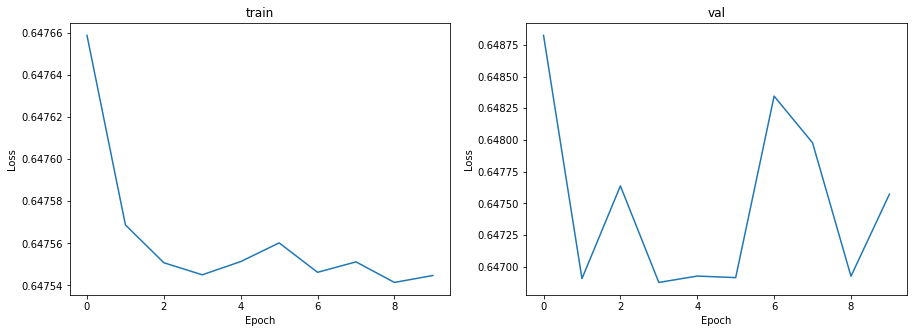

In [10]:
# Plot the cost over training and validation sets
fig,ax = plt.subplots(1,2,figsize=(15,5))
for i,key in enumerate(cost_paths.keys()):
    ax_sub=ax[i%3]
    ax_sub.plot(cost_paths[key])
    ax_sub.set_title(key)
    ax_sub.set_xlabel('Epoch')
    ax_sub.set_ylabel('Loss')
plt.show()